<a href="https://colab.research.google.com/github/nemo0001/Python/blob/master/Kaggle_HRv13_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  

Saving HRDataset_v13.csv to HRDataset_v13.csv
User uploaded file "HRDataset_v13.csv" with length 82237 bytes


In [0]:
"""Data description
Description of fields is available here : https://rpubs.com/rhuebner/HRCodebook-13

Employee Name : Employee’s full name
EmpID : Employee ID is unique to each employee
MarriedID : Is the person married (1 or 0 for yes or no)
MaritalStatusID : Marital status code that matches the text field MaritalDesc
EmpStatusID : Employment status code that matches text field EmploymentStatus
DeptID : Department ID code that matches the department the employee works in
PerfScoreID : Performance Score code that matches the employee’s most recent performance score
FromDiversityJobFairID : Was the employee sourced from the Diversity job fair? 1 or 0 for yes or no
PayRate : The person’s hourly pay rate. All salaries are converted to hourly pay rate
Termd : Has this employee been terminated - 1 or 0
PositionID : An integer indicating the person’s position
Position : The text name/title of the position the person has
State : The state that the person lives in
Zip : The zip code for the employee
DOB : Date of Birth for the employee
Sex : Sex - M or F
MaritalDesc : The marital status of the person (divorced, single, widowed, separated, etc)
CitizenDesc : Label for whether the person is a Citizen or Eligible NonCitizen
HispanicLatino : Yes or No field for whether the employee is Hispanic/Latino
RaceDesc : Description/text of the race the person identifies with
DateofHire : Date the person was hired
DateofTermination : Date the person was terminated, only populated if, in fact, Termd = 1
TermReason : A text reason / description for why the person was terminated
EmploymentStatus : A description/category of the person’s employment status. Anyone currently working full time = Active
Department : Name of the department that the person works in
ManagerName : The name of the person’s immediate manager
ManagerID : A unique identifier for each manager.
RecruitmentSource : The name of the recruitment source where the employee was recruited from
PerformanceScore : Performance Score text/category (Fully Meets, Partially Meets, PIP, Exceeds)
EngagementSurvey : Results from the last engagement survey, managed by our external partner
EmpSatisfaction : A basic satisfaction score between 1 and 5, as reported on a recent employee satisfaction survey
SpecialProjectsCount : The number of special projects that the employee worked on during the last 6 months
LastPerformanceReviewDate : The most recent date of the person’s last performance review.
DaysLateLast30 : The number of times that the employee was late to work during the last 30 days"""

In [0]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = (16, 9)

In [7]:
HR=pd.read_csv('HRDataset_v13.csv',skiprows=range(312,450))
HR.dropna(how='all',inplace=True)
HR.head()
HR.tail(10)
# HR.shape

,Employee_Name,EmpID,MarriedID,MaritalStatusID,GenderID,EmpStatusID,DeptID,PerfScoreID,FromDiversityJobFairID,PayRate,Termd,PositionID,Position,State,Zip,DOB,Sex,MaritalDesc,CitizenDesc,HispanicLatino,RaceDesc,DateofHire,DateofTermination,TermReason,EmploymentStatus,Department,ManagerName,ManagerID,RecruitmentSource,PerformanceScore,EngagementSurvey,EmpSatisfaction,SpecialProjectsCount,LastPerformanceReview_Date,DaysLateLast30
300,"Boutwell, Bonalyn",1.307060e+09,1.0,1.0,0.0,1.0,1.0,3.0,1.0,34.95,0.0,26.0,Sr. Accountant,MA,2468.0,04/04/87,F,Married,US Citizen,No,Asian,2/16/2015,NaN,N/A - still employed,Active,Admin Offices,Brandon R. LeBlanc,3.0,Diversity Job Fair,Fully Meets,5.00,4.0,3.0,2/18/2019,0.0
301,"Ait Sidi, Karthikeyan",1.307060e+09,1.0,1.0,1.0,5.0,3.0,3.0,0.0,62.00,1.0,27.0,Sr. DBA,MA,2148.0,05/05/75,M,Married,US Citizen,No,White,3/30/2015,06/16/16,career change,Voluntarily Terminated,IT/IS,Simon Roup,4.0,Company Intranet - Partner,Fully Meets,4.96,3.0,6.0,NaN,NaN
302,"Carr, Claudia N",1.010022e+09,0.0,0.0,0.0,2.0,3.0,3.0,0.0,61.30,0.0,27.0,Sr. DBA,MA,1886.0,06/06/86,F,Single,US Citizen,No,Black or African American,6/30/2016,NaN,N/A - Has not started yet,Future Start,IT/IS,Simon Roup,4.0,Vendor Referral,Fully Meets,5.00,5.0,6.0,2/18/2019,0.0
303,"Favis, Donald",1.412072e+09,0.0,0.0,1.0,4.0,3.0,3.0,0.0,58.20,1.0,30.0,Enterprise Architect,CT,6033.0,07/30/64,M,Single,US Citizen,No,Black or African American,2/17/2014,02/19/16,hours,Terminated for Cause,IT/IS,Simon Roup,4.0,Vendor Referral,Fully Meets,2.94,5.0,7.0,NaN,NaN
304,"Roehrich, Bianca",1.111030e+09,0.0,0.0,0.0,5.0,3.0,3.0,0.0,58.50,1.0,29.0,Principal Data Architect,MA,2703.0,05/27/73,F,Single,US Citizen,Yes,White,1/5/2015,11/10/15,Another position,Voluntarily Terminated,IT/IS,Simon Roup,4.0,Vendor Referral,Fully Meets,3.88,3.0,7.0,NaN,NaN
305,"Daniele, Ann",1.411071e+09,1.0,1.0,0.0,3.0,3.0,3.0,0.0,54.10,0.0,28.0,Sr. Network Engineer,CT,6033.0,01/18/52,F,Married,US Citizen,No,White,11/10/2014,NaN,N/A - still employed,Leave of Absence,IT/IS,Peter Monroe,7.0,Vendor Referral,Fully Meets,1.55,5.0,8.0,2/12/2019,0.0
306,"Lajiri, Jyoti",1.108028e+09,1.0,1.0,1.0,3.0,3.0,3.0,0.0,56.20,0.0,28.0,Sr. Network Engineer,MA,2169.0,04/23/86,M,Married,US Citizen,No,White,11/10/2014,NaN,N/A - still employed,Leave of Absence,IT/IS,Peter Monroe,7.0,Employee Referral,Fully Meets,4.46,5.0,6.0,1/7/2019,0.0
307,"Semizoglou, Jeremiah",9.040136e+08,1.0,1.0,1.0,2.0,3.0,3.0,0.0,53.80,0.0,28.0,Sr. Network Engineer,MA,1545.0,02/09/83,M,Married,US Citizen,No,Asian,6/30/2016,NaN,N/A - Has not started yet,Future Start,IT/IS,Peter Monroe,7.0,On-campus Recruiting,Fully Meets,3.27,4.0,5.0,1/14/2019,0.0
308,"South, Joe",1.308061e+09,0.0,0.0,1.0,1.0,3.0,3.0,0.0,53.00,0.0,28.0,Sr. Network Engineer,CT,6278.0,09/09/65,M,Single,US Citizen,No,White,11/10/2014,NaN,N/A - still employed,Active,IT/IS,Peter Monroe,7.0,Employee Referral,Fully Meets,5.00,3.0,4.0,1/2/2019,0.0
309,"Warfield, Sarah",1.301052e+09,0.0,4.0,0.0,1.0,3.0,3.0,0.0,55.20,0.0,28.0,Sr. Network Engineer,MA,2453.0,05/02/78,F,Widowed,US Citizen,No,Asian,3/30/2015,NaN,N/A - still employed,Active,IT/IS,Peter Monroe,7.0,Employee Referral,Fully Meets,1.06,4.0,8.0,2/5/2019,0.0


In [8]:
# Missing Values
missings = HR.isnull().sum()
print(missings[missings>0])


DateofTermination             207
TermReason                      1
ManagerID                       8
LastPerformanceReview_Date    103
DaysLateLast30                103
dtype: int64


In [9]:
#Pre processing and feature engineering
# Missing values
HR['DaysLateLast30'] = HR['DaysLateLast30'].fillna(-1)

# Conversion to datatime
HR['DateofHire'] = pd.to_datetime(HR['DateofHire'], dayfirst = False)
HR['DOB'] = pd.to_datetime(HR['DOB'], dayfirst = False)
HR['DateofTermination'] = pd.to_datetime(HR['DateofTermination'], dayfirst = False)
HR['LastPerformanceReview_Date'] = pd.to_datetime(HR['LastPerformanceReview_Date'], dayfirst = False)
 
#df['Last_Name'] = df['Employee_Name'].apply(lambda name: name.split(',')[0].strip())
#df['first_Name'] = df['Employee_Name'].apply(lambda name: name.split(',')[1].strip() if ("," in name) else "")

#Cleaning
HR["Sex"] = HR["Sex"].str.strip()
#bining PayRate
bins = [10,20,30,40,50,60,70,80,90]
labels = [10,20,30,40,50,60,70,80]
HR["PayRateBin10"] = pd.cut(HR["PayRate"], bins)
HR.head(10)

,Employee_Name,EmpID,MarriedID,MaritalStatusID,GenderID,EmpStatusID,DeptID,PerfScoreID,FromDiversityJobFairID,PayRate,Termd,PositionID,Position,State,Zip,DOB,Sex,MaritalDesc,CitizenDesc,HispanicLatino,RaceDesc,DateofHire,DateofTermination,TermReason,EmploymentStatus,Department,ManagerName,ManagerID,RecruitmentSource,PerformanceScore,EngagementSurvey,EmpSatisfaction,SpecialProjectsCount,LastPerformanceReview_Date,DaysLateLast30,PayRateBin10
0,"Brown, Mia",1.103024e+09,1.0,1.0,0.0,1.0,1.0,3.0,1.0,28.50,0.0,1.0,Accountant I,MA,1450.0,1987-11-24,F,Married,US Citizen,No,Black or African American,2008-10-27,NaT,N/A - still employed,Active,Admin Offices,Brandon R. LeBlanc,1.0,Diversity Job Fair,Fully Meets,2.04,2.0,6.0,2019-01-15,0.0,"(20, 30]"
1,"LaRotonda, William",1.106027e+09,0.0,2.0,1.0,1.0,1.0,3.0,0.0,23.00,0.0,1.0,Accountant I,MA,1460.0,1984-04-26,M,Divorced,US Citizen,No,Black or African American,2014-01-06,NaT,N/A - still employed,Active,Admin Offices,Brandon R. LeBlanc,1.0,Website Banner Ads,Fully Meets,5.00,4.0,4.0,2019-01-17,0.0,"(20, 30]"
2,"Steans, Tyrone",1.302053e+09,0.0,0.0,1.0,1.0,1.0,3.0,0.0,29.00,0.0,1.0,Accountant I,MA,2703.0,1986-09-01,M,Single,US Citizen,No,White,2014-09-29,NaT,N/A - still employed,Active,Admin Offices,Brandon R. LeBlanc,1.0,Internet Search,Fully Meets,3.90,5.0,5.0,2019-01-18,0.0,"(20, 30]"
3,"Howard, Estelle",1.211051e+09,1.0,1.0,0.0,1.0,1.0,3.0,0.0,21.50,1.0,2.0,Administrative Assistant,MA,2170.0,1985-09-16,F,Married,US Citizen,No,White,2015-02-16,2015-04-15,NaN,Terminated for Cause,Admin Offices,Brandon R. LeBlanc,1.0,Pay Per Click - Google,Fully Meets,3.24,3.0,4.0,NaT,-1.0,"(20, 30]"
4,"Singh, Nan",1.307060e+09,0.0,0.0,0.0,1.0,1.0,3.0,0.0,16.56,0.0,2.0,Administrative Assistant,MA,2330.0,1988-05-19,F,Single,US Citizen,No,White,2015-05-01,NaT,N/A - still employed,Active,Admin Offices,Brandon R. LeBlanc,1.0,Website Banner Ads,Fully Meets,5.00,3.0,5.0,2019-01-15,0.0,"(10, 20]"
5,"Smith, Leigh Ann",7.110077e+08,1.0,1.0,0.0,5.0,1.0,3.0,1.0,20.50,1.0,2.0,Administrative Assistant,MA,1844.0,1987-06-14,F,Married,US Citizen,No,Asian,2011-09-26,2013-09-25,career change,Voluntarily Terminated,Admin Offices,Brandon R. LeBlanc,1.0,Diversity Job Fair,Fully Meets,3.80,4.0,4.0,NaT,-1.0,"(20, 30]"
6,"Bunbury, Jessica",1.504073e+09,1.0,1.0,0.0,5.0,6.0,3.0,0.0,55.00,1.0,3.0,Area Sales Manager,VA,21851.0,2064-06-01,F,Married,Eligible NonCitizen,No,Black or African American,2011-08-15,2014-08-02,Another position,Voluntarily Terminated,Sales,John Smith,17.0,Social Networks - Facebook Twitter etc,Fully Meets,3.14,5.0,0.0,NaT,-1.0,"(50, 60]"
7,"Carter, Michelle",1.403066e+09,0.0,0.0,0.0,1.0,6.0,3.0,0.0,55.00,0.0,3.0,Area Sales Manager,VT,5664.0,2063-05-15,F,Single,US Citizen,No,White,2014-08-18,NaT,N/A - still employed,Active,Sales,John Smith,17.0,Billboard,Fully Meets,5.00,5.0,0.0,2019-01-21,0.0,"(50, 60]"
8,"Dietrich, Jenna",1.408069e+09,0.0,0.0,0.0,1.0,6.0,1.0,0.0,55.00,0.0,3.0,Area Sales Manager,WA,98052.0,1987-05-14,F,Single,US Citizen,Yes,White,2012-02-20,NaT,N/A - still employed,Active,Sales,John Smith,17.0,Website Banner Ads,PIP,2.30,1.0,0.0,2019-01-29,0.0,"(50, 60]"
9,"Digitale, Alfred",1.306059e+09,1.0,1.0,1.0,1.0,6.0,3.0,0.0,56.00,0.0,3.0,Area Sales Manager,NH,3062.0,1988-09-14,M,Married,US Citizen,No,American Indian or Alaska Native,2014-08-18,NaT,N/A - still employed,Active,Sales,John Smith,17.0,Pay Per Click - Google,Fully Meets,3.60,5.0,0.0,2019-01-30,0.0,"(50, 60]"


In [10]:
"""New column : Number of days present in the company

if terminated (DateofTermination - DateofHire)
else (Today - DateofHire)
What is today ?

I've taken the last performance review date"""

HR['LastDayWorked'] = HR['DateofTermination']
HR['LastDayWorked'].fillna(HR['LastPerformanceReview_Date'].max(),inplace=True)
HR['NbrDayWorked'] = (HR['LastDayWorked']-HR['DateofHire'])//np.timedelta64(1,'D')
del HR['LastDayWorked']
print(HR['NbrDayWorked'].max(),HR['NbrDayWorked'].min())

4798 2


In [0]:
"""New column : Gap to median of the pay rate in the position group"""
HR["PayRateMedianPosition"] = HR.groupby(['Position'])["PayRate"].transform('median')
HR["PayRateEcart"] = HR["PayRate"] - HR["PayRateMedianPosition"]

In [17]:
#Normalization by Nature
#Columns to keep by nature
keepColId = ['MarriedID', 'FromDiversityJobFairID','Termd']
keepColNum = ['NbrDayWorked','PayRateEcart', 'EngagementSurvey', 'EmpSatisfaction','SpecialProjectsCount']
keepColCat = ['Sex', 'MaritalDesc', 'CitizenDesc','Department', 'PerformanceScore']

# Normalization
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaledData = scaler.fit_transform(HR[keepColNum])
scaledData=pd.DataFrame(scaledData,columns=keepColNum)
scaledData.head()
# OneHotEncoding
data = pd.concat([scaledData,HR[keepColId], pd.get_dummies(HR[keepColCat]),HR['EmploymentStatus']], axis=1)
data.head()
#Features
X=data.loc[data['EmploymentStatus'].isin(['Active','Voluntarily Terminated'])].copy()
# #Target
y=X['Termd']

X.drop(["Termd",'EmploymentStatus'], axis=1, inplace=True)
X.head()

,NbrDayWorked,PayRateEcart,EngagementSurvey,EmpSatisfaction,SpecialProjectsCount,MarriedID,FromDiversityJobFairID,Sex_F,Sex_M,MaritalDesc_Divorced,MaritalDesc_Married,MaritalDesc_Separated,MaritalDesc_Single,MaritalDesc_Widowed,CitizenDesc_Eligible NonCitizen,CitizenDesc_Non-Citizen,CitizenDesc_US Citizen,Department_Admin Offices,Department_Executive Office,Department_IT/IS,Department_Production,Department_Sales,Department_Software Engineering,PerformanceScore_Exceeds,PerformanceScore_Fully Meets,PerformanceScore_Needs Improvement,PerformanceScore_PIP
0,2.431974,0.036295,-1.002786,-2.079060,2.039987,1.0,1.0,1,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0
1,0.309309,-1.409217,1.294446,0.120628,1.188275,0.0,0.0,0,1,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0
2,0.011666,0.167705,0.440745,1.220472,1.614131,0.0,0.0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1,0,0
4,-0.227791,-0.999217,1.294446,-0.979216,1.614131,0.0,0.0,1,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1,0,0
5,-0.976375,0.036295,0.363136,0.120628,1.188275,1.0,1.0,1,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0


In [18]:
"""Data exploration with a decision tree
The purpose is to see the factors that have the most importance in a decision tree.
The target decision is Terminated or Not Terminated
The employment status are :

Active = 1
Future Start = 2
Leave of Absence = 3
Terminated for Cause = 4
Voluntarily Terminated = 5
Termd column :

Termd = 0 means No Terminated, i.e. [Active,Future Start,Leave of Absence]
Termd = 1 means Terminated, i.e. [Terminated for Cause, Voluntarily Terminated]"""

pd.crosstab(HR['Termd'], HR['EmploymentStatus'])

EmploymentStatus,Active,Future Start,Leave of Absence,Terminated for Cause,Voluntarily Terminated
Termd,,,,,
0.0,182,11,14,0,0
1.0,0,0,0,15,88


In [0]:
#splitting train test data
from sklearn import tree
import graphviz
from sklearn.model_selection import train_test_split

X_trainset, X_testset, y_trainset, y_testset = train_test_split(X, y, test_size=0.3, random_state=3)


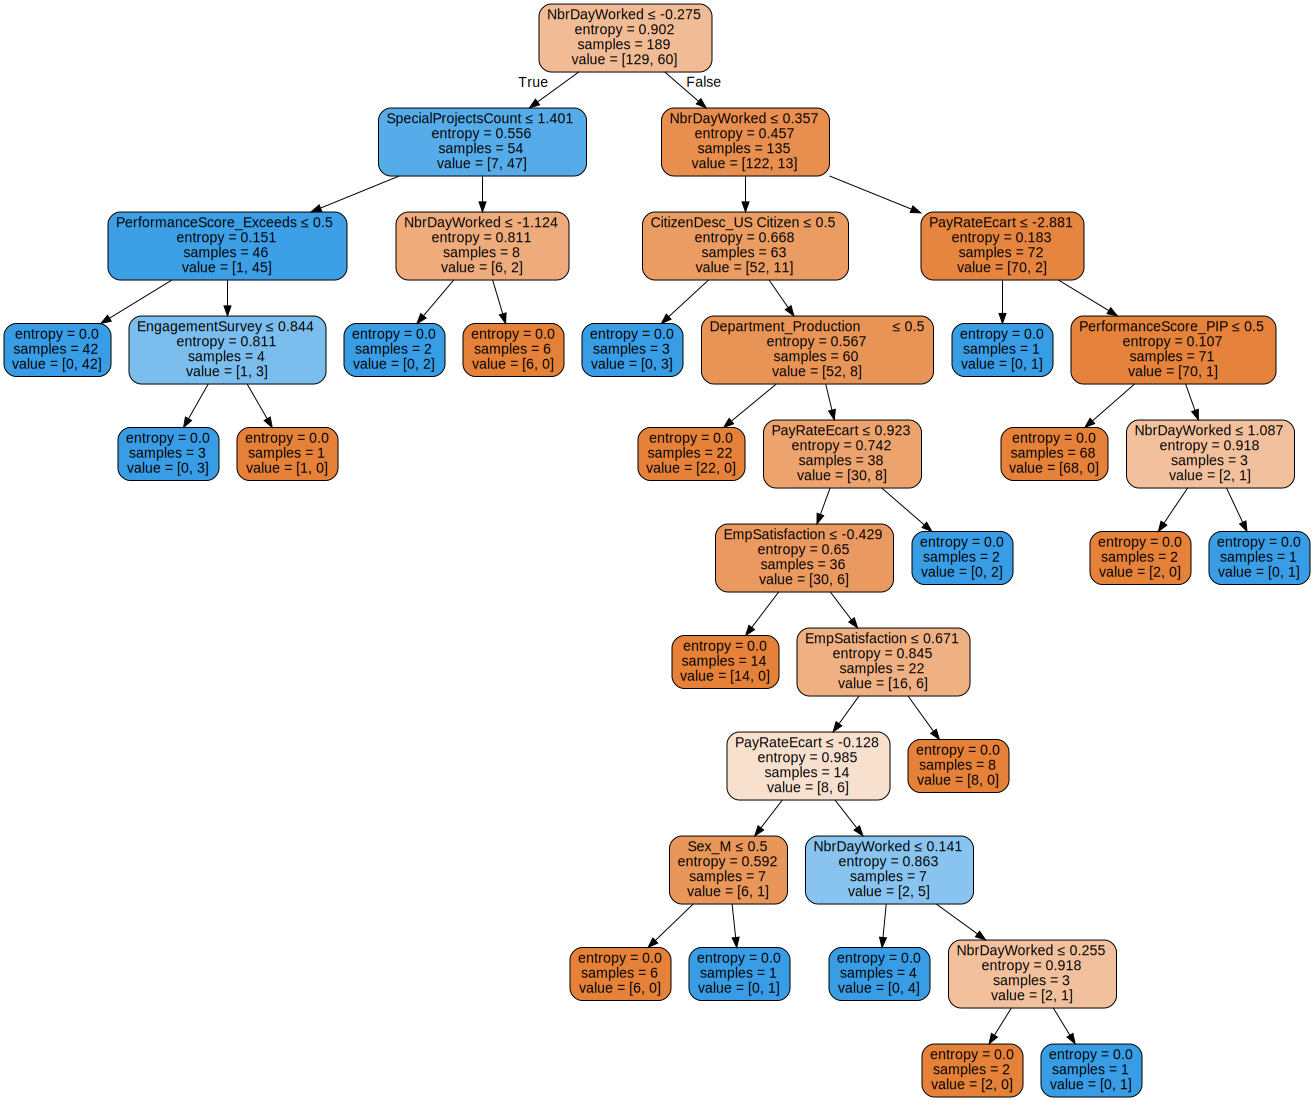

In [21]:
#modelling
clf =tree.DecisionTreeClassifier(criterion="entropy")
clf.fit(X_trainset,y_trainset)

dot_data = tree.export_graphviz(clf, out_file=None, 
                     feature_names=X.columns,  
                     filled=True, rounded=True,  
                     special_characters=True)  
graph = graphviz.Source(dot_data)  
graph  

In [0]:
#Prediction
Predclf = clf.predict(X_testset)

In [23]:
#evalution
from sklearn import metrics
import matplotlib.pyplot as plt
print("DecisionTrees's Accuracy: ", metrics.accuracy_score(y_testset, Predclf))

DecisionTrees's Accuracy:  0.9135802469135802


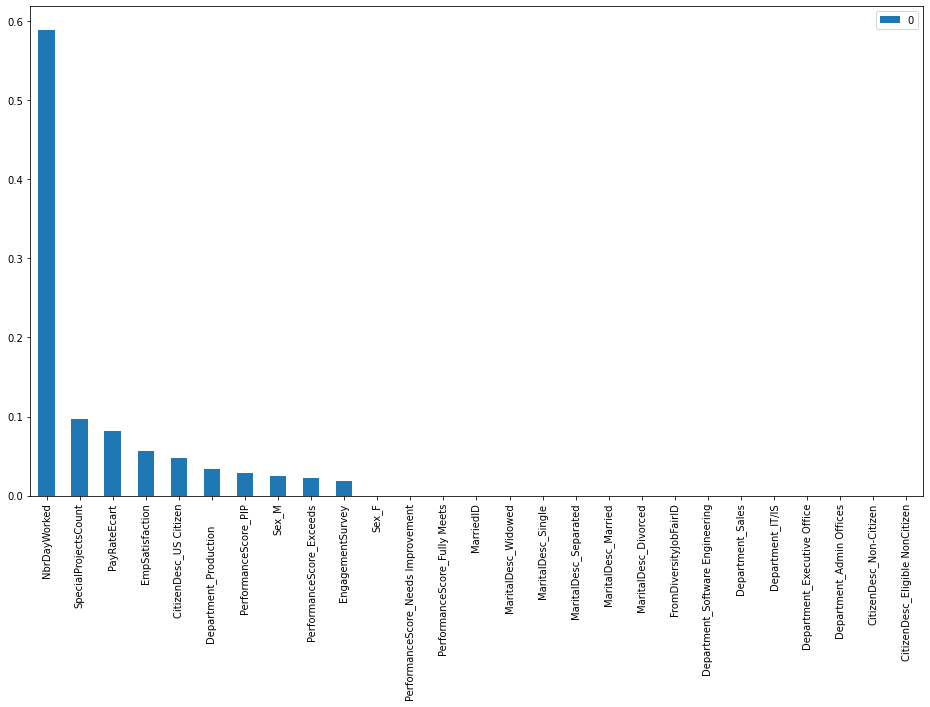

In [24]:
"""The features that have the most importances in the decision are :"""
columns = X_trainset.columns
importances = list(zip(clf.feature_importances_,columns))
importances.sort(reverse=True)
pd.DataFrame(importances, index=[x for (_,x) in importances]).plot(kind = 'bar');